# 0. Imports and Help Fuctions

In [1]:
import pandas as pd 
import inflection
import math
import numpy as np
import seaborn as sns
import xgboost as xgb

from matplotlib                        import pyplot as plt
from IPython.core.display              import HTML
from IPython.display                   import Image
from scipy                             import stats
from sklearn.ensemble                  import RandomForestRegressor
from tabulate                          import tabulate
from sklearn.preprocessing             import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model              import LinearRegression, Lasso
from sklearn.metrics                   import mean_absolute_error, mean_squared_error
from boruta                            import BorutaPy

## 0.1 Helper Fuctions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def mean_absolute_percentage_erro (y, yhat): 
    return np.mean(np.abs( ( y - yhat ) / y ))
    

    
def m1_error(model_name, y, yhat):
    mae  = mean_absolute_error( y, yhat) 
    mape = mean_absolute_percentage_erro(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({"Model Name:": model_name,
                         "MAE":  mae,
                         "MAPE": mape, 
                         "RMSE": rmse}, index=[0])


def cross_validation(x_training, kfold, model_name, model):
    mae_list  =  []
    mape_list =  []
    rmse_list =  []
    
    for k in reversed( range( 1, kfold+1 ) ):
        print(f"KFold Number: {k}")
        #start and end date for validation
        validation_start_date = x_training["date"].max() - datetime.timedelta( days=k*6*7)
        validation_end_date   = x_training["date"].max() - datetime.timedelta( days=(k-1)*6*7)

        #filtering dataset
        training = x_training[x_training["date"] < validation_start_date]
        validation = x_training[(x_training["date"] >= validation_start_date) & (x_training["date"] <= validation_end_date)]


        #training 
        xtraining = training.drop(["date", "sales"], axis=1)
        ytraining = training["sales"]

        #validation
        xvalidation = validation.drop(["date","sales"], axis=1)
        yvalidation = validation["sales"]

        #model 
        m = model.fit( xtraining, ytraining )

        #prediction 
        yhat = m.predict( xvalidation )

        #performance 
        m_result = m1_error( model_name, np.expm1(yvalidation), np.expm1(yhat))

        #store performance of each kfold iteration 
        mae_list.append(  m_result["MAE"] )
        mape_list.append( m_result["MAPE"] )
        rmse_list.append( m_result["RMSE"])

    return     pd.DataFrame({"Model Name": model_name,
                                 "MAE CV":  np.round(np.mean(mae_list),2).astype(str) + " +/- "  +   np.round( np.std( mae_list ), 2 ).astype( str ), 
                                 "MAPE CV": np.round(np.mean(mape_list),2).astype(str) + " +/- " +   np.round( np.std( mape_list ), 2 ).astype( str ),
                                 "RMS CV":  np.round(np.mean(rmse_list),2).astype(str) + " +/- "  +  np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0])

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv("datas/train.csv", low_memory = False)
df_store_raw = pd.read_csv("datas/store.csv", low_memory = False)
df_raw = pd.merge( df_sales_raw,df_store_raw, how="left", on = "Store" )

# 1. Descrição dos Dados

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list ( map(snakecase, cols_old ))

df1.columns = cols_new

In [7]:
cols_new

['store',
 'day_of_week',
 'date',
 'sales',
 'customers',
 'open',
 'promo',
 'state_holiday',
 'school_holiday',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_interval']

## 1.2 Data Dimension

In [8]:
print(f"Number of rows {df1.shape[0]}")
print(f"Number of columns {df1.shape[1]}")

Number of rows 1017209
Number of columns 18


## 1.3 Data Types

In [9]:
df1["date"] = pd.to_datetime( df1["date"] )

In [10]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

Temos alguns dados faltantes em promo. e também em competition_distance

## 1.5 Fillout NA

In [12]:
#competition_distance   
df1["competition_distance"] = df1["competition_distance"].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month 
df1["competition_open_since_month"] = df1.apply( lambda x: x["date"].month if math.isnan(x["competition_open_since_month"]) 
                                                else x["competition_open_since_month"], axis=1)

#competition_open_since_year 
df1["competition_open_since_year"] = df1.apply( lambda x: x["date"].year if math.isnan(x["competition_open_since_year"]) 
                                                else x["competition_open_since_year"], axis=1)

#promo2_since_week   
df1["promo2_since_week"] = df1.apply( lambda x: x["date"].week if math.isnan(x["promo2_since_week"]) 
                                                else x["promo2_since_week"], axis=1)

#promo2_since_year 
df1["promo2_since_year"] = df1.apply( lambda x: x["date"].year if math.isnan(x["promo2_since_year"]) 
                                                else x["promo2_since_year"], axis=1)

#promo_interval                  
month_map = {1: "Jan", 2: "Fev", 3: "Mar",4: "Apr",5: "May",6: "Jun",7: "Jul",8: "Aug",9: "Sept", 10: "Oct", 11: "Nov", 12: "Dez"}

df1["promo_interval"].fillna(0,inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1) 

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types 

In [14]:
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype( int64 )
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype( int64 )

df1["promo2_since_week"] = df1["promo2_since_week"].astype( int )
df1["promo2_since_year"] = df1["promo2_since_year"].astype( int )

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical 

In [16]:
num_attributes = df1.select_dtypes( include = ["int64", "float64", "int32"])
cat_attributes = df1.select_dtypes( exclude = ["int64", "float64", "datetime64[ns]"])

### 1.7.1 Numerical Attributes

In [17]:
# central tendency - mean, median 
ct1 = pd.DataFrame(num_attributes.apply( np.mean   )).T
ct2 = pd.DataFrame(num_attributes.apply( np.median )).T


# dispersion - std, min, max, range, skew, kurtosis 
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T


#concatenate 
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns= ["attributes","min", "max","range","mean","median","std","skew","kurtosis"]

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

With boxplot

In [18]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday         4
store_type            4
assortment            3
promo2_since_week    52
promo2_since_year     7
promo_interval        4
month_map            12
dtype: int64

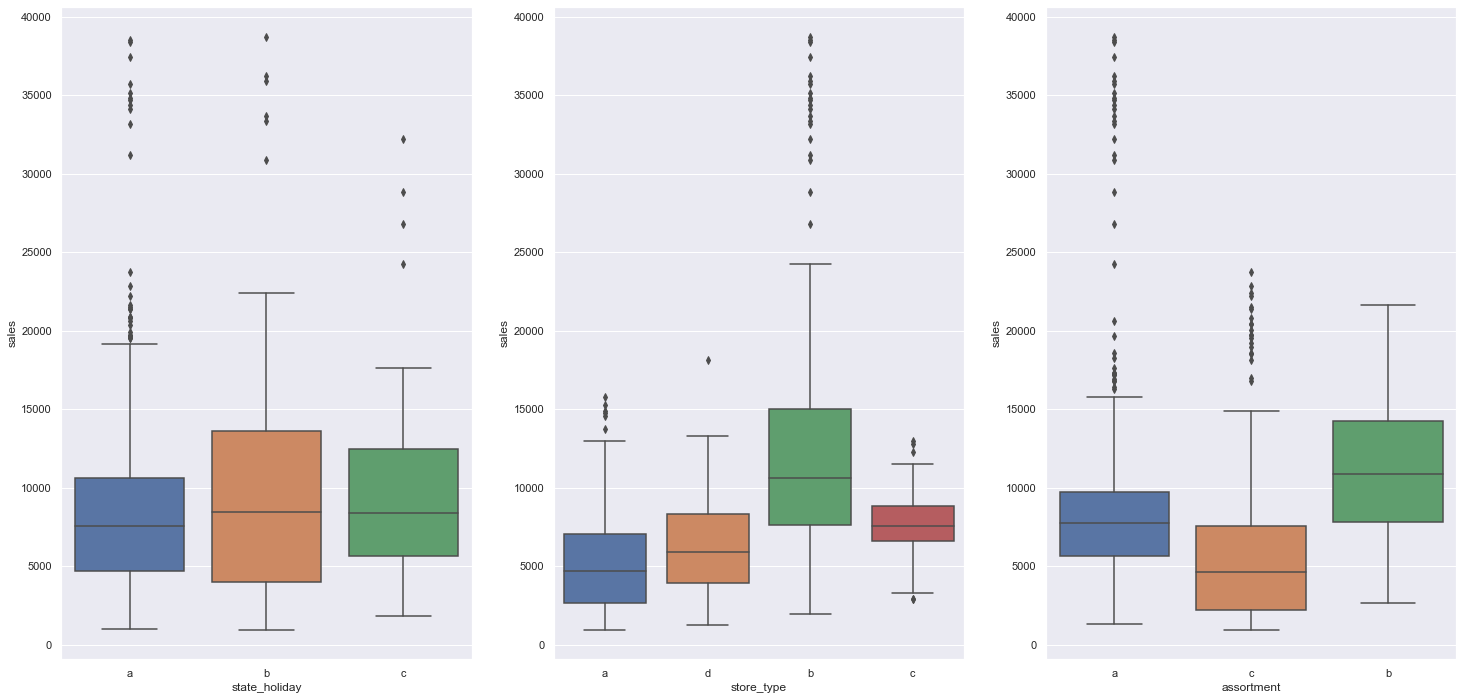

In [19]:
aux1 = df1[(df1["state_holiday"] !="0") & (df1["sales"] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x="state_holiday", y="sales", data=aux1);

plt.subplot(1,3,2)
sns.boxplot( x="store_type" , y="sales", data=aux1);

plt.subplot(1,3,3)
sns.boxplot( x="assortment" , y="sales", data=aux1);

# 2. Feature Engineering

In [20]:
df2 = df1.copy()

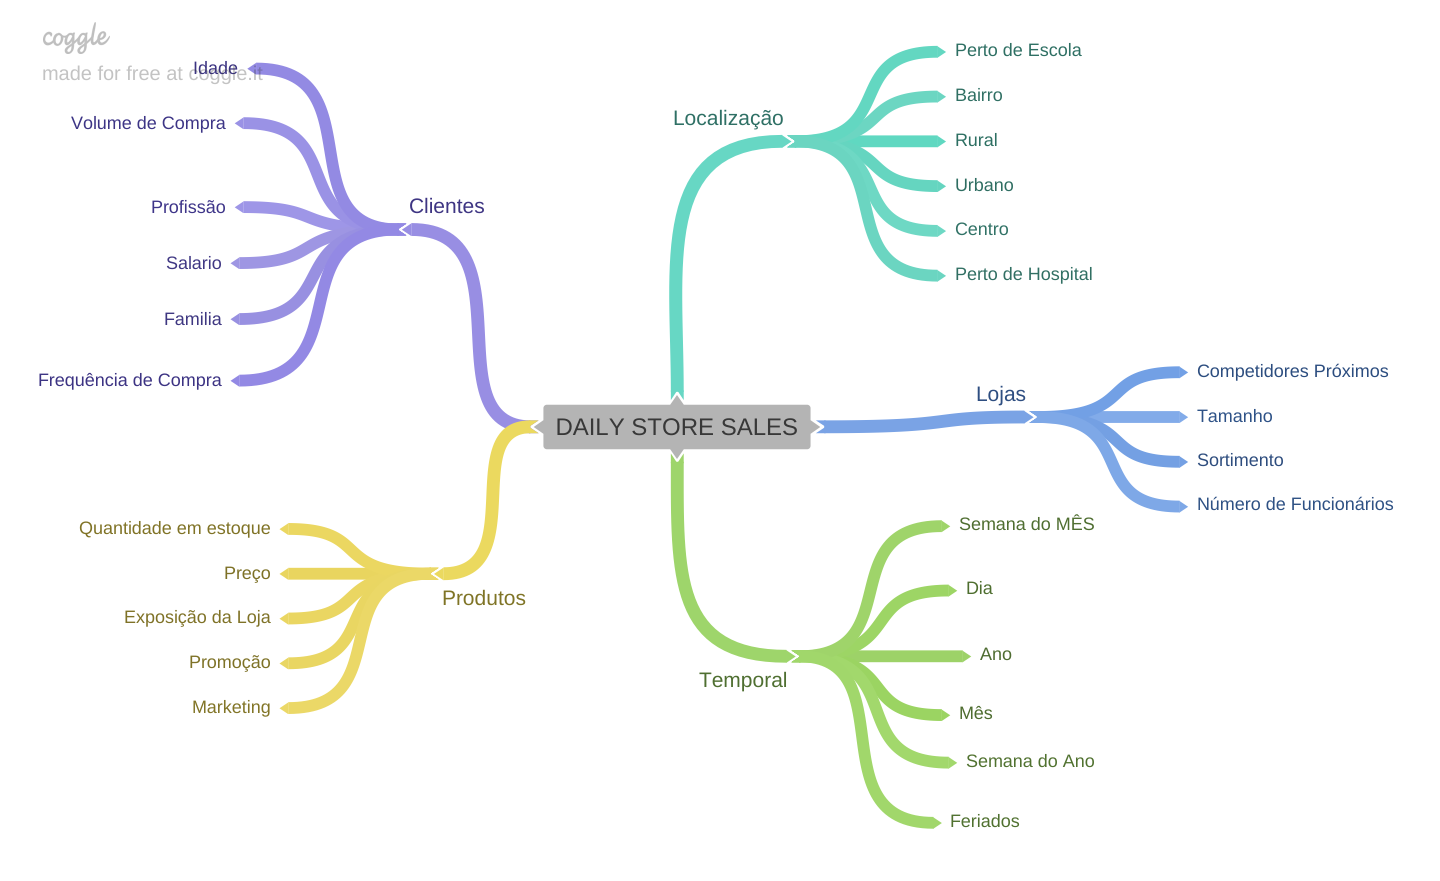

In [21]:
Image("datas/img/DAILY_STORE_SALES.png")

## 2.1 Criação de Hipóteses

**Hipoteses são somente uma correlação : Não é uma causa e efeito**

## 2.2 Hipóteses 

Não temos disponíveis todos os dataseets possíveis, por isso vamos filtrar algumas hipóteses que conseguimos solucionar com o que temos. 

CICLO 1 - CRISP

**PRIORIZAÇÃO DAS HIPÓTESES**

### 2.2.1 Hipóteses Lojas

**1.** Lojas com maior sortimento deveriam vender mais 

**2.** Lojas com competidores mais próximos deveriam vender menos 

**3.** Lojas com mais competidores a mais tempo deveriam vender mais  

### 2.2.2 Hipóteses Produto

**1.** Lojas com romoções ativas por mais tempo deveriam vender mais 

**2.** Lojas com mais dias de promoções deveriam vender mais 

**3.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.2.3 Hipóteses Tempo 

**1.** Lojas que tem mais feriados deveriam vender menos. 


**2.** Lojas que abrem nos primeiros seis meses deveriam vender mais. 


**3.** Lojas que abrem nos finais de semana deveriam vender mais. 


**4.** Lojas com abertuda durante o Natal deveriam vender mais 


**5.** Lojas deveriam vender mais ao longo dos anos 


**6.** Lojas deveriam vender mais depois do dia 10 de todo mês 


**7.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Feature Engineering

In [22]:
# YEAR 
df2["year"] = df2["date"].dt.year

# MONTH 
df2["month"] = df2["date"].dt.month 

# DAY 
df2["day"] = df2["date"].dt.day 

# WEEK OF WEEK 
df2["week_of_year"] = df2["date"].dt.weekofyear 

# year week 
df2["year_week"] = df2["date"].dt.strftime( "%Y-%w" )

# COMPETITION SINCE 
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )


# PROMO SINCE 
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )


#ASSORTMENT 
df2["assortment"] = df2["assortment"].apply( lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended")

#STATE HOLIDAY 
df2["state_holiday"] = df2["state_holiday"].apply( lambda x: "public_holiday" if x == "a" else "easter_holiday" if x == "b" else "chistmas"  if x == "c" else "regular_day")

<ipython-input-22-d0564ccfe6a0>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2["week_of_year"] = df2["date"].dt.weekofyear


# 3. Filtragem de Variáveis 

In [23]:
df3 = df2.copy()

In [24]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-5,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-5,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-5,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-5,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-5,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [25]:
df3 = df3[(df3["open"] != 0) & (df3["sales"] > 0)]

## 3.2 Selação das colunas

In [26]:
df3.drop( ["customers","open", "promo_interval", "month_map"], axis=1, inplace=True)

# 4. Exploratory Analysis

In [27]:
df4 = df3.copy()

## 4.1 Análise Univariada 

### 4.1.1 Response Variable

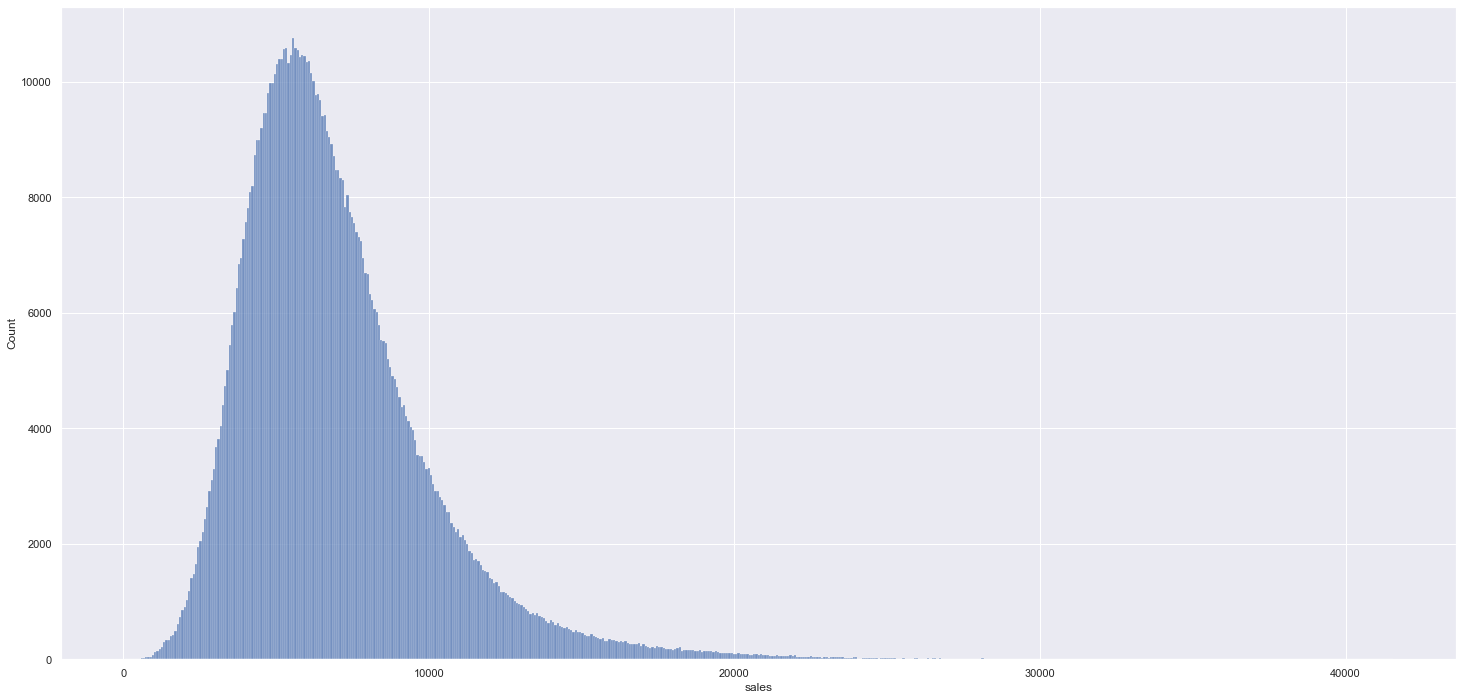

In [28]:
sns.histplot( df4["sales"]);

### 4.1.2 Numerical Variable

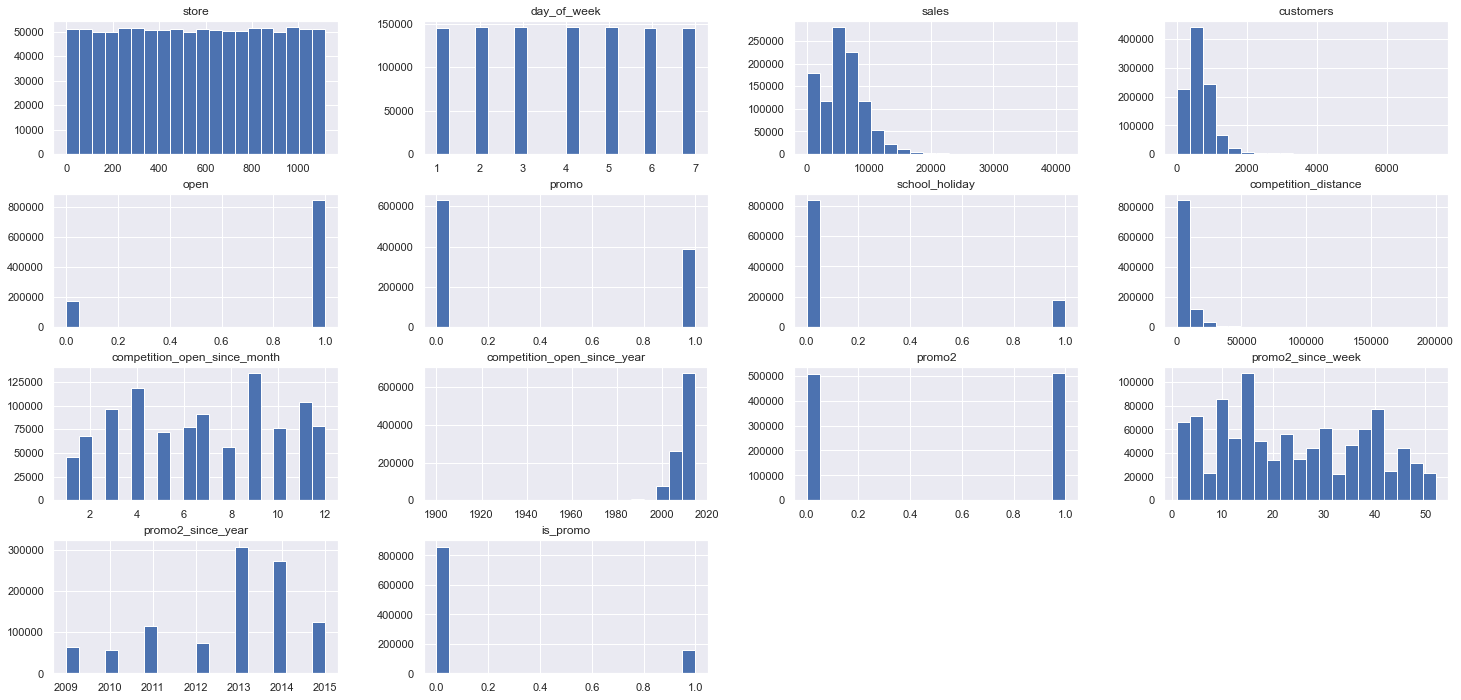

In [29]:
num_attributes.hist(bins = 20); 

### 4.1.3 Categorical Variable

In [30]:
df4["state_holiday"].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126          chistmas
Name: state_holiday, dtype: object

C:\Users\guisg\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\guisg\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\guisg\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


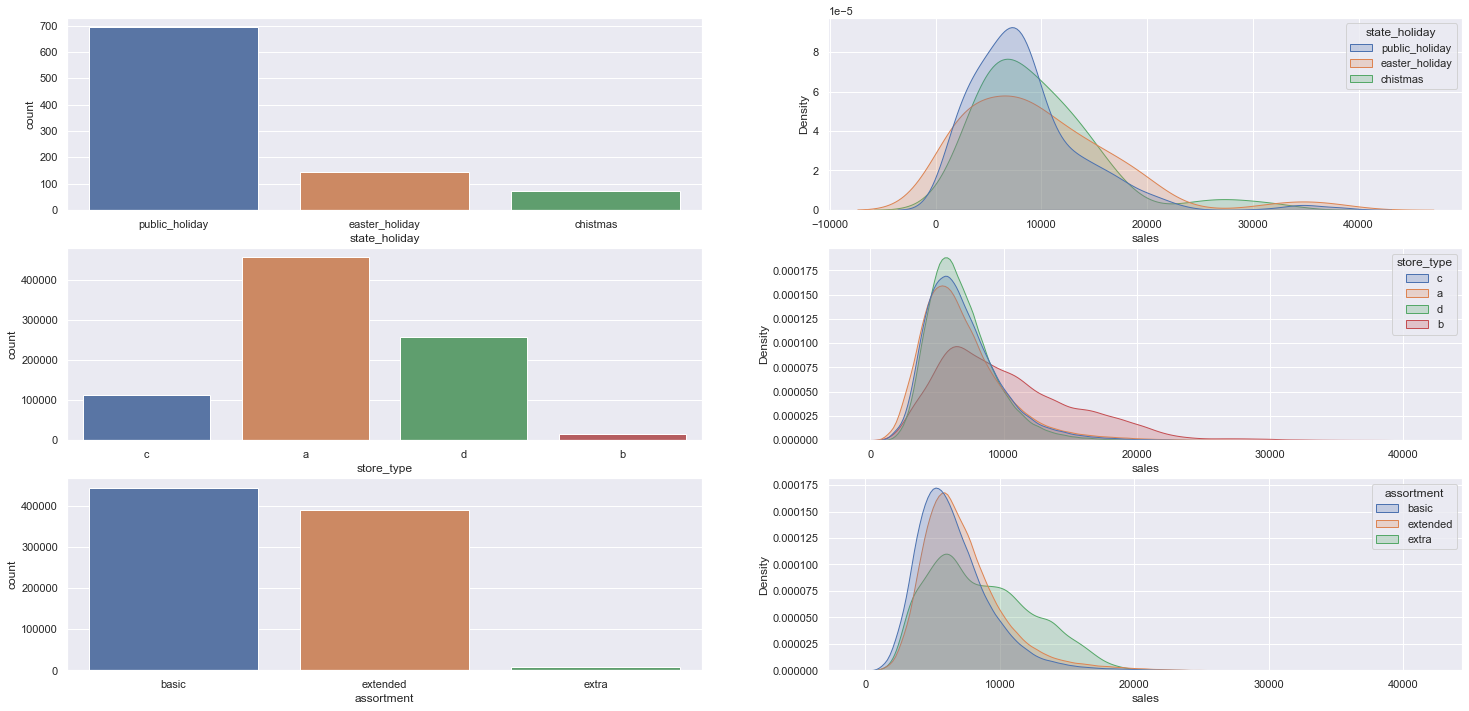

In [31]:
#state_holiday
plt.subplot(3,2,1)
a = df4[df4["state_holiday"] != "regular_day"]
sns.countplot( a["state_holiday"] )

plt.subplot(3,2,2)
sns.kdeplot(data = a, x= 'sales', hue ='state_holiday',fill = True, common_norm = False );


#store_type
plt.subplot(3,2,3)
sns.countplot( df4["store_type"] )
plt.subplot(3,2,4)
sns.kdeplot(data = df4, x= 'sales', hue = 'store_type',fill = True, common_norm = False );

#assortment
plt.subplot(3,2,5)
sns.countplot( df4["assortment"] )

plt.subplot(3,2,6)
sns.kdeplot(data = df4, x='sales', hue = 'assortment',fill = True, common_norm = False );

## 4.2 Análise Bivariada 

### **H1.** Lojas com maior sortimento deveriam vender mais
**FALSA** Lojas com maior sortimento vendem menos

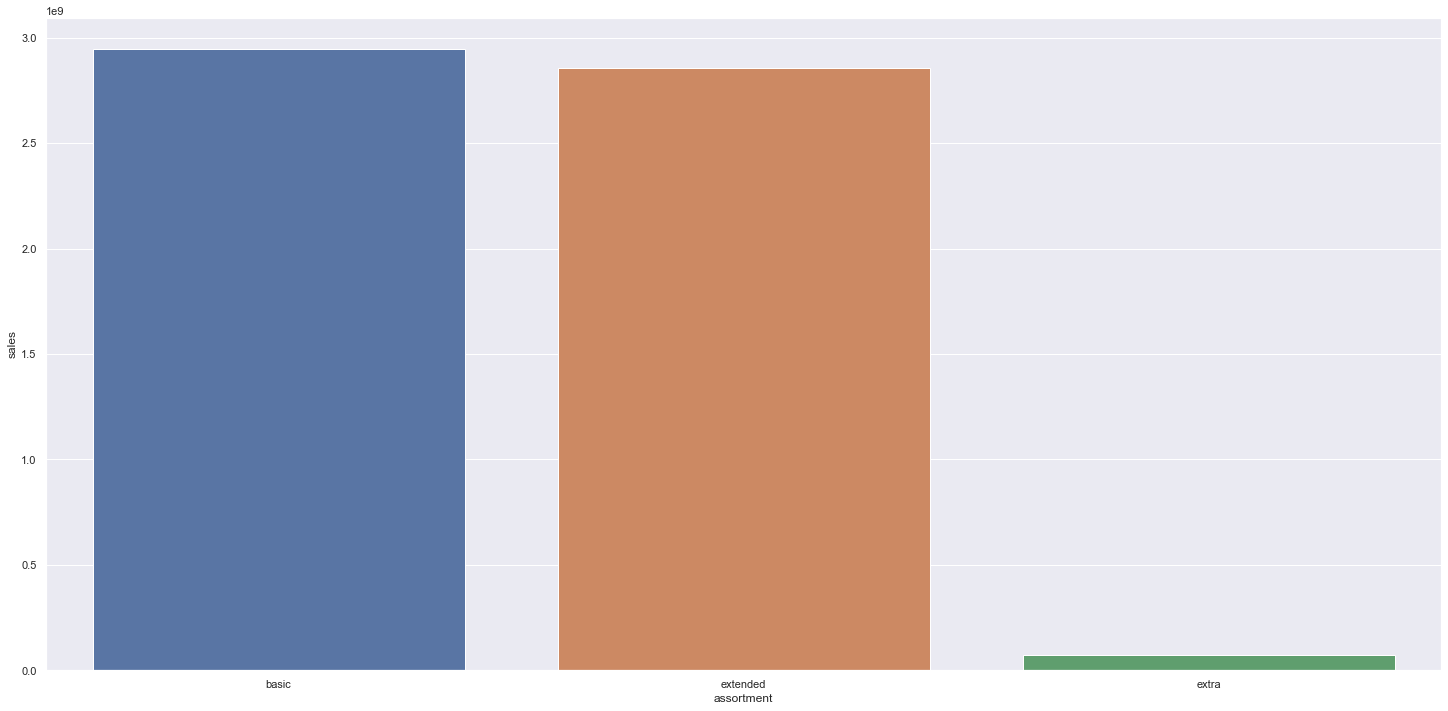

In [32]:
aux = df4[["assortment", "sales"]].groupby( "assortment" ).sum().reset_index()
sns.barplot( x="assortment", y="sales", data=aux);

Lojas com assortment extra vendem menos do que lojas com extended (médias).


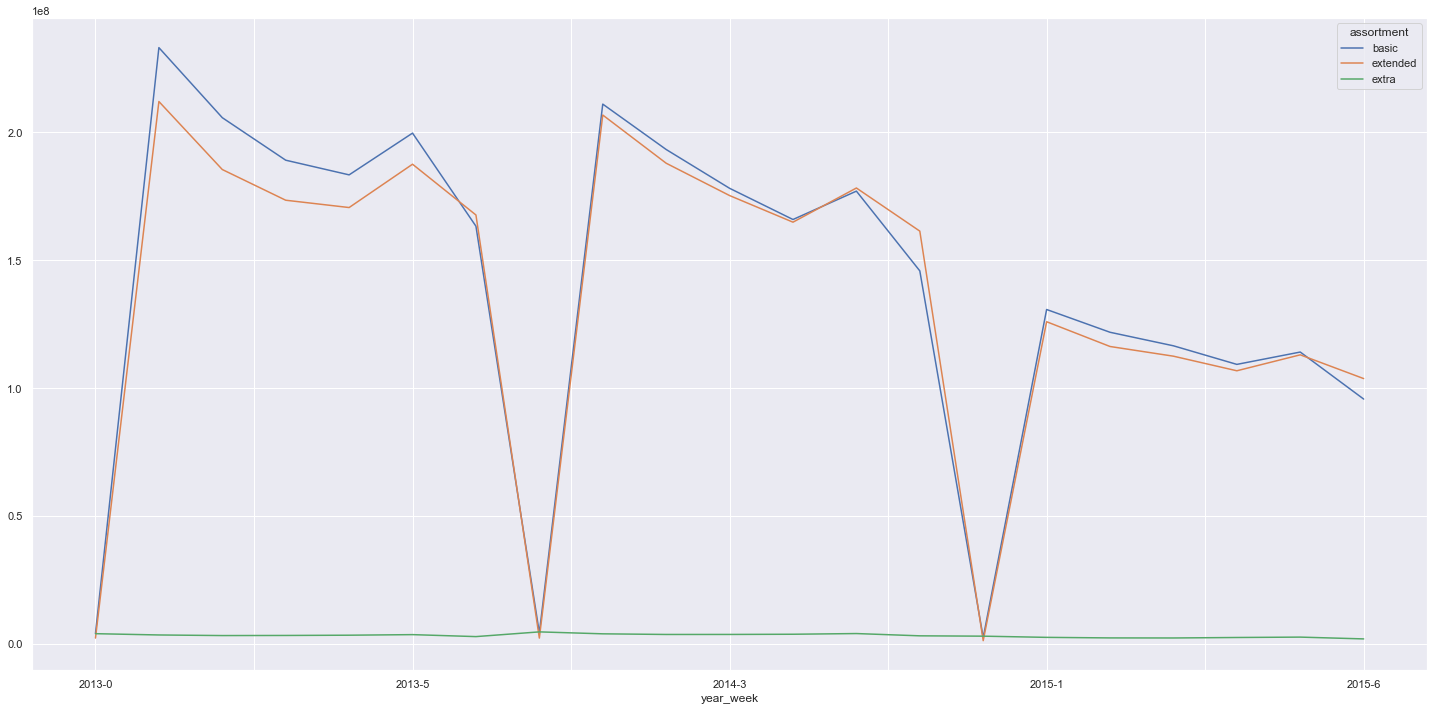

In [33]:
aux2 = df4[["year_week","assortment", "sales"]].groupby( ["year_week","assortment"] ).sum().reset_index()
aux3 = aux2.pivot( index="year_week", columns="assortment", values="sales").plot();

<AxesSubplot:xlabel='year_week'>

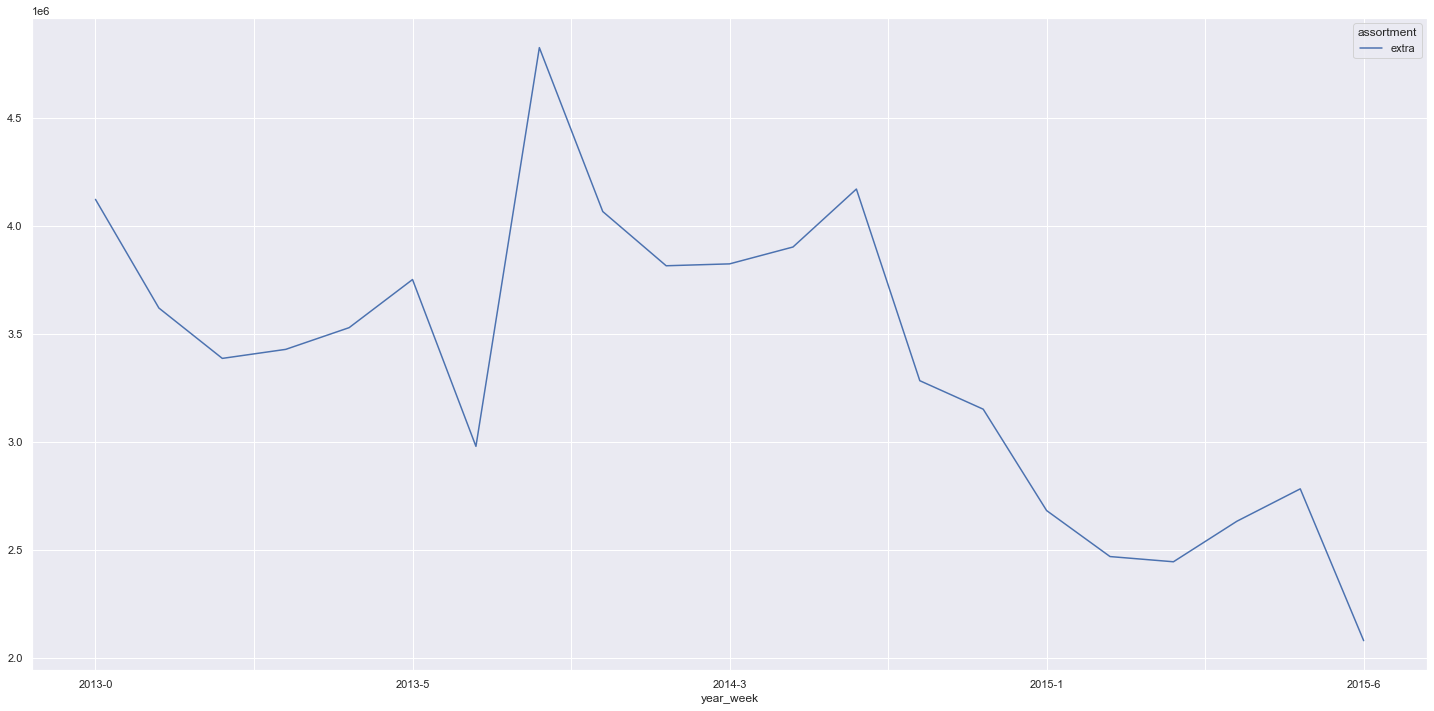

In [34]:
aux4 = aux2[aux2["assortment"]=="extra"]
aux4.pivot(index="year_week", columns="assortment", values="sales").plot()


### **H2.** Lojas com competidores mais próximos deveriam vender menos. 

**FALSA** Lojas com competidores mais próximos vendem MAIS

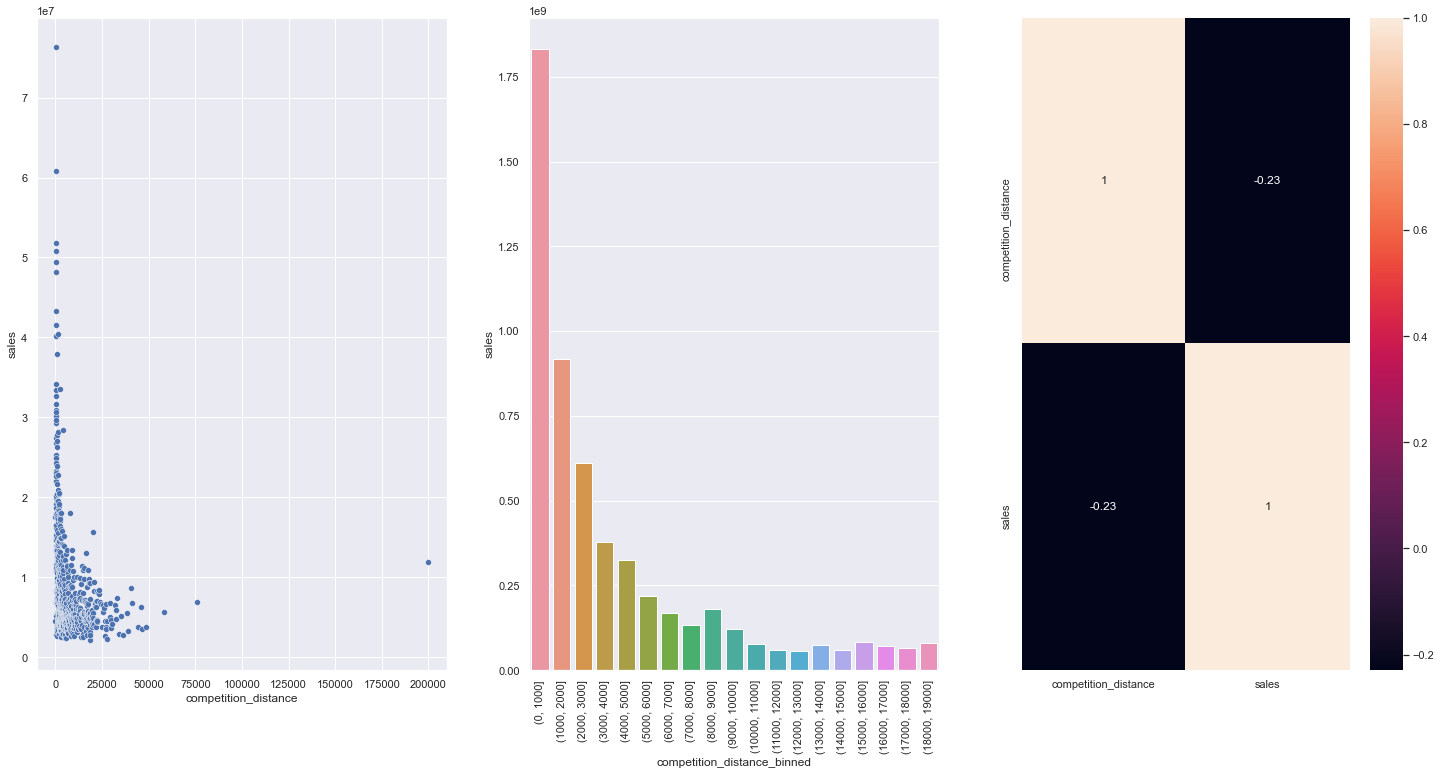

In [35]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );


plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'],bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 ); #giramos 90 graus


plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

Competidores mais próximos vendem mais. 

Fenômenos Macro-econômico

### **H3.** Lojas com competidores à mais tempo deveriam vender mais. 
**FALSA** Lojas com competidores a mais tempo vendem MENOS. 

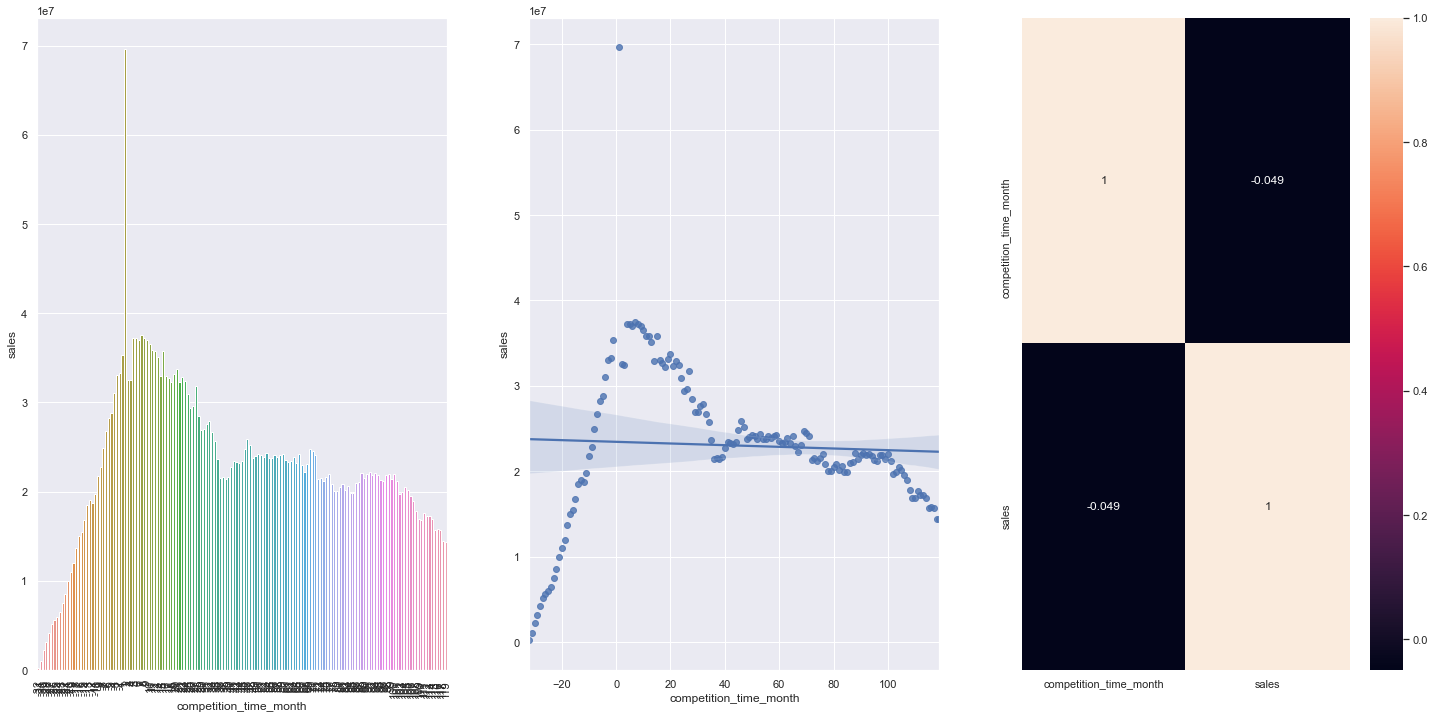

In [36]:
aux1 = df4[["competition_time_month", "sales"]].groupby("competition_time_month").sum().reset_index()

plt.subplot(1 , 3, 1)
aux2 = aux1[(aux1["competition_time_month"] < 120) & (aux1["competition_time_month"] != 0)]
sns.barplot(x="competition_time_month", y="sales",data=aux2); #mês que o competidor começou
plt.xticks( rotation=90 ); #giramos 90 graus a legenda

plt.subplot(1 , 3, 2)
sns.regplot(x="competition_time_month", y="sales", data=aux2);

plt.subplot(1 , 3, 3)
sns.heatmap( aux2.corr(method="pearson"), annot=True);

Quanto mais recente as competições mais vendemos. 

Loja com competidores a mais tempo vendem menos 

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais. 
**FALSA** Lojas com promoções ativas por mais tempo vendem menos após um período de promoção 

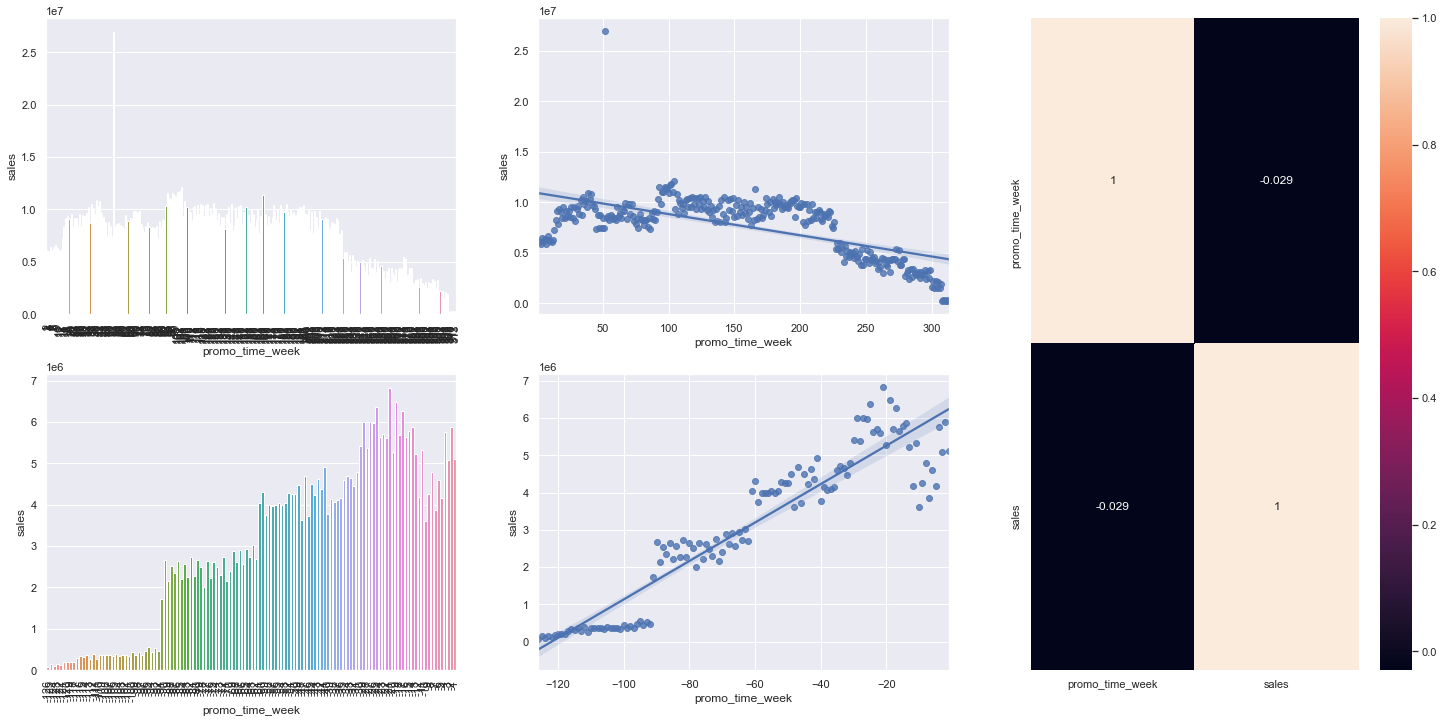

In [37]:
aux1 = df4[["promo_time_week", "sales"]].groupby("promo_time_week").sum().reset_index()
sns.barplot(x="promo_time_week", y="sales", data=aux1);

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[ aux1["promo_time_week"] > 0 ] #promo extendido
sns.barplot(x="promo_time_week", y="sales", data=aux2)
plt.xticks( rotation=90 ); #giramos 90 graus a legenda

plt.subplot(grid[0,1])
sns.regplot(x="promo_time_week", y="sales", data=aux2)


plt.subplot(grid[1,0])
aux3 = aux1[ aux1["promo_time_week"] < 0 ] #promo extendido
sns.barplot(x="promo_time_week", y="sales", data=aux3)
plt.xticks( rotation=90 ); #giramos 90 graus a legenda

plt.subplot(grid[1,1])
sns.regplot(x="promo_time_week", y="sales", data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method="pearson"), annot=True);

Promoção extendida tem um período que tem um efeito maior, depois há um decaimento. 

Antes da promoção há um salto de compras (figura 2) 

**RELEVÂNCIA PARA O MODELO-> FEATURE NÃO MUITO RELEVANTE**

### <s> H5. Lojas com mais dias de promoção deveriam vender mais </s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais. 
**FALSA**  Lojas com mais promoções consecutivas vendem menos

In [38]:
df4[["promo","promo2","sales"]].groupby( [ "promo","promo2" ]).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


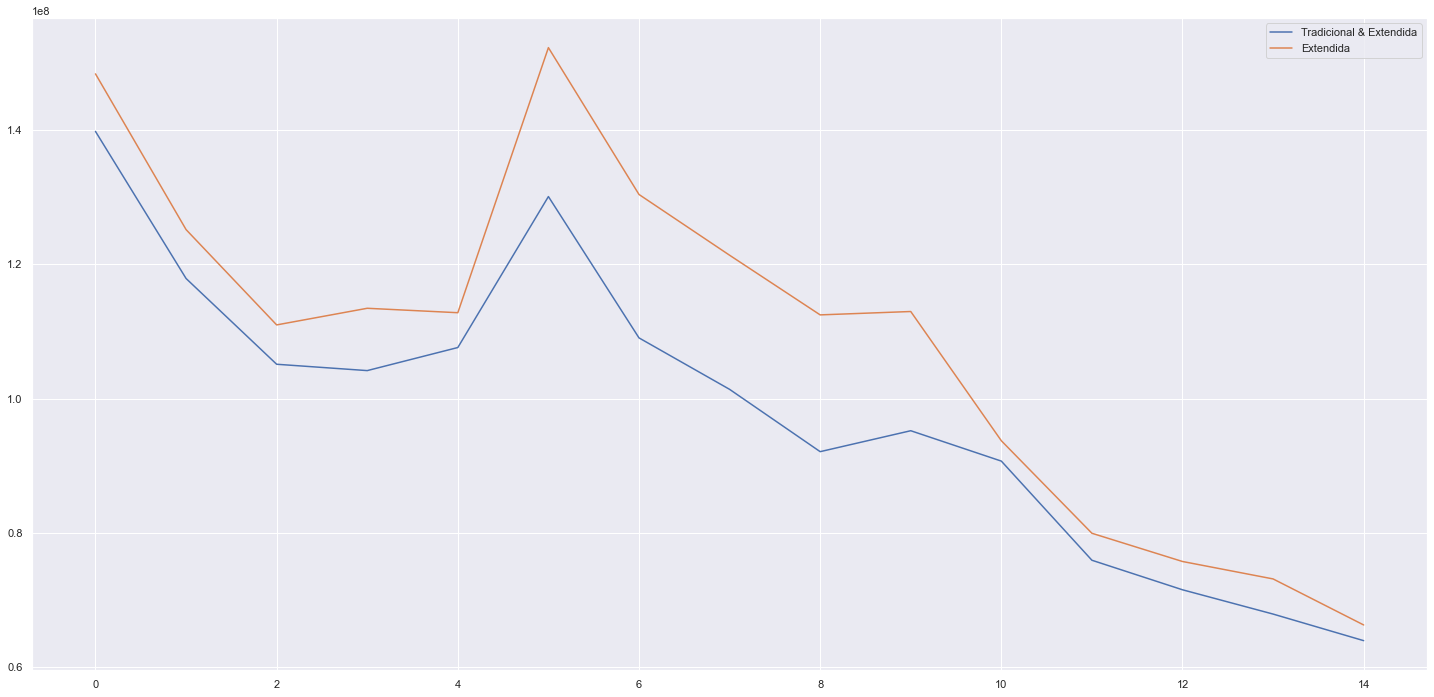

In [39]:
aux1 = df4[( df4["promo"] == 1 ) & ( df4["promo2"] == 1 )][["year_week","sales"]].groupby("year_week").sum().reset_index()
ax = aux1.plot()


aux2 = df4[( df4["promo"] == 1 ) & ( df4["promo2"] == 0 )][["year_week","sales"]].groupby("year_week").sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=["Tradicional & Extendida", "Extendida"]);

### H8. Lojas abertas durante o feriado de Natal deveriam vender mais. 

**FALSO** Natal não vende mais que os outros feriados

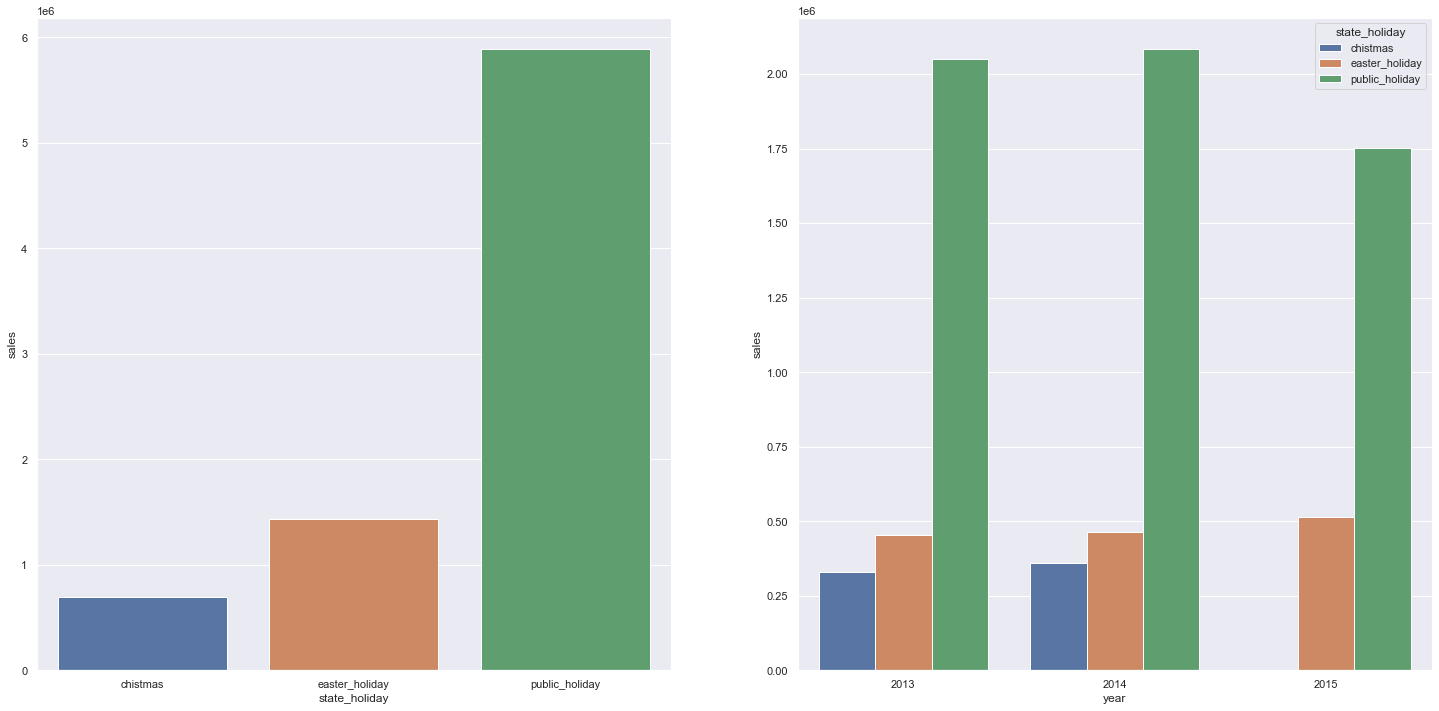

In [40]:
aux  = df4[df4["state_holiday"] != "regular_day"]
aux1 = aux[["state_holiday","sales"]].groupby("state_holiday").sum().reset_index()

plt.subplot(1,2,1)
sns.barplot( x="state_holiday", y = "sales", data=aux1 );

plt.subplot(1,2,2)
aux2 = aux[["year", "state_holiday", "sales"]].groupby(["year", "state_holiday"]).sum().reset_index()
sns.barplot(x="year", y="sales", hue="state_holiday", data=aux2);

### H9. Lojas deveriam vender mais ao longo dos anos. 

**FALSO** Lojas vendem menos ano longo dos anos 

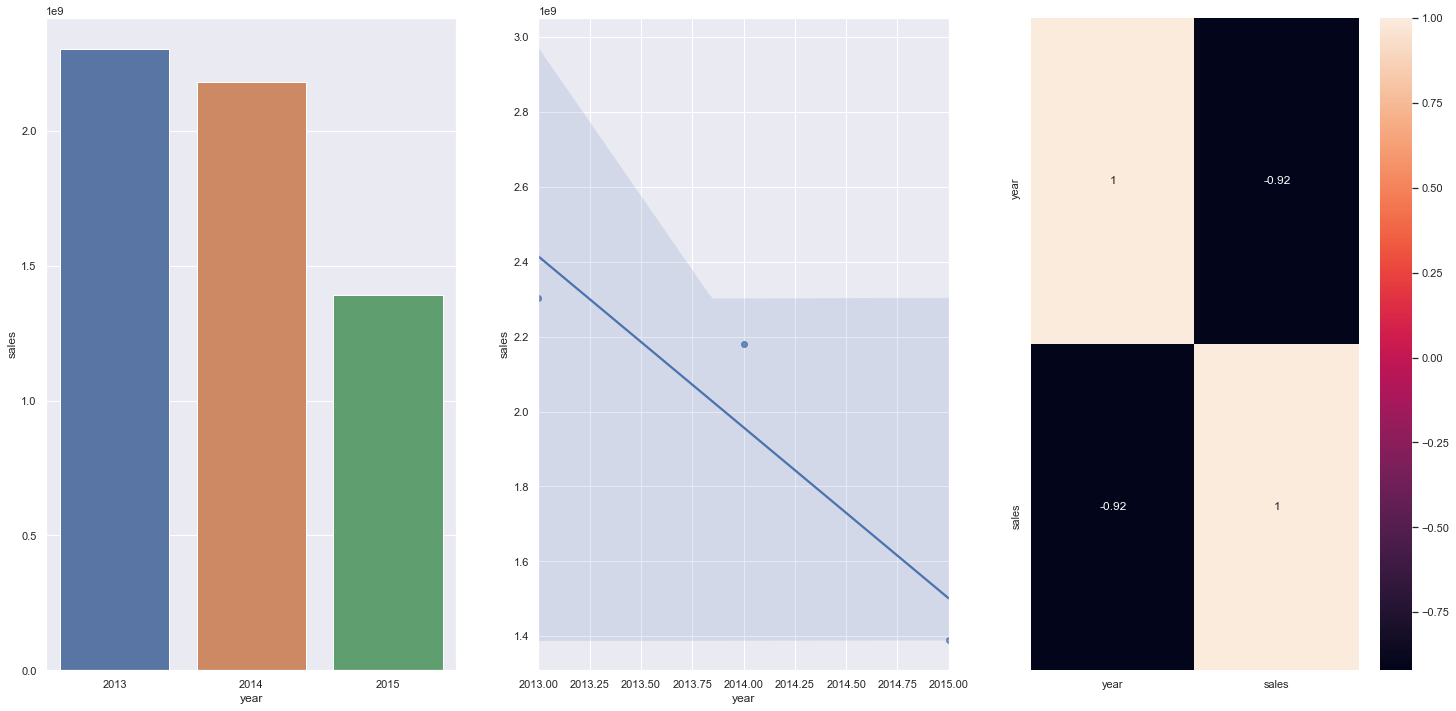

In [41]:
aux1 = df4[["year","sales"]].groupby("year").sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x="year", y="sales", data=aux1);

plt.subplot(1,3,2)
sns.regplot(x="year", y="sales", data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method="pearson"), annot=True);

### H10. Lojas deveriam vender mais no segundo semestre do ano.

**FALSO** Lojas da Rossman vendem menos 

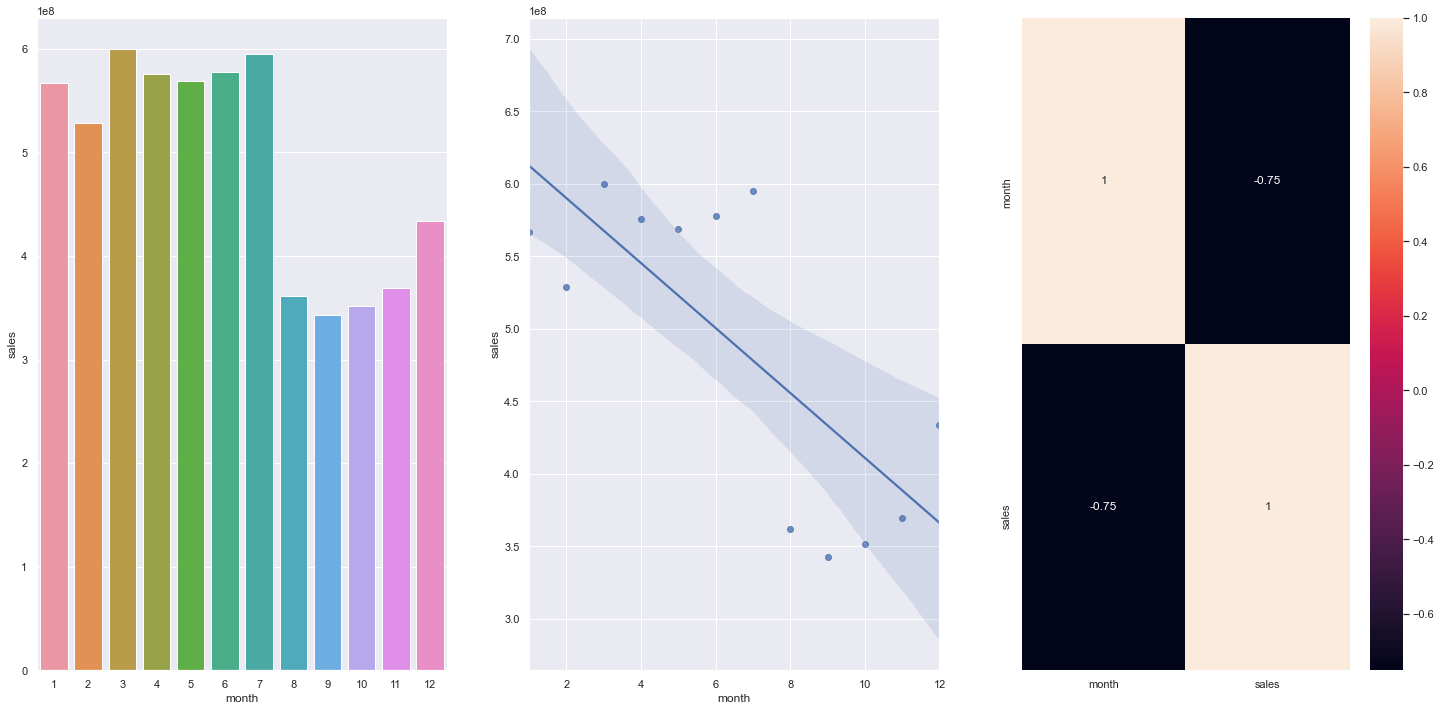

In [42]:
aux1 = df4[["month","sales"]].groupby("month").sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x="month", y="sales", data=aux1);

plt.subplot(1,3,2)
sns.regplot(x="month", y="sales", data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method="pearson"), annot=True);

### H11. Lojas deveriam vender mais depois de 10 dias de cada mês. 

**VERDADEIRA** Lojas vendem mais depois de 10 dias de cada Mês 

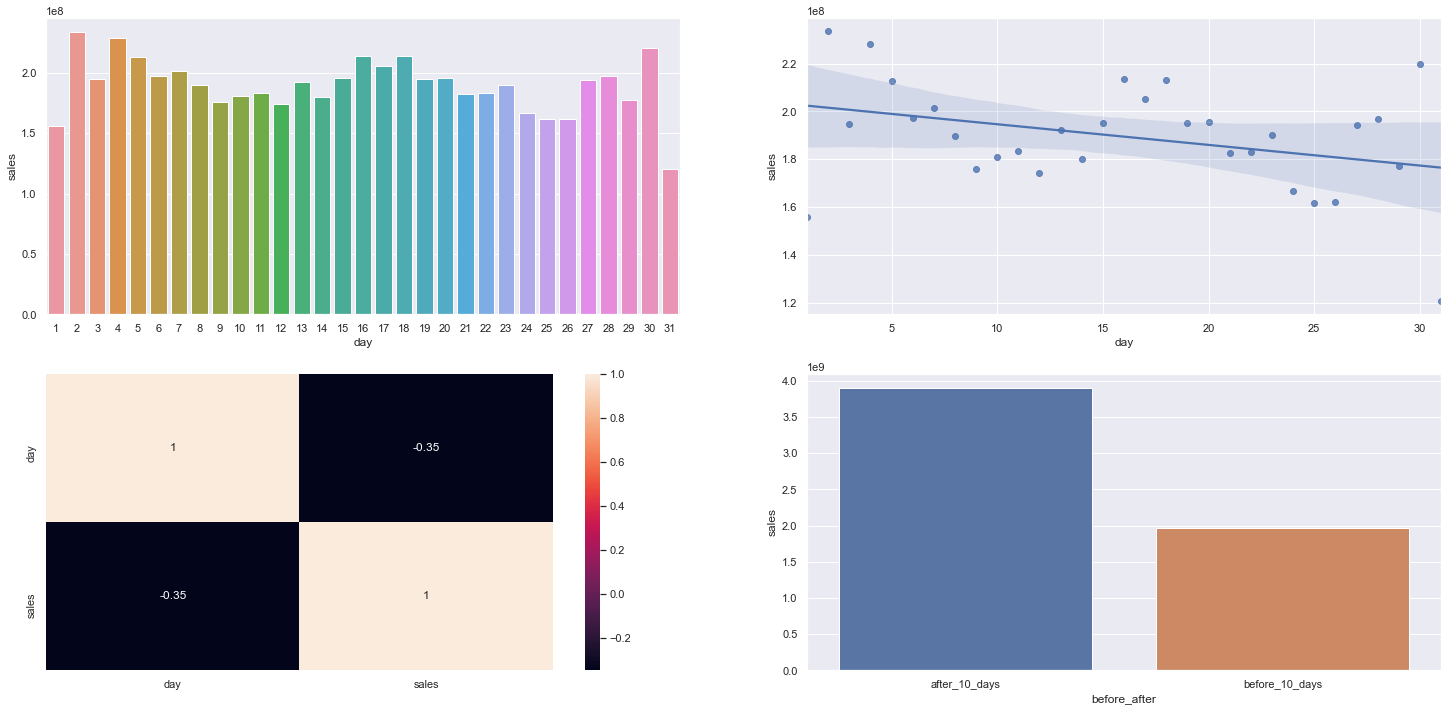

In [43]:
aux1 = df4[["day","sales"]].groupby("day").sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x="day", y="sales", data=aux1);

plt.subplot(2,2,2)
sns.regplot(x="day", y="sales", data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method="pearson"), annot=True);

aux1["before_after"] = aux1["day"].apply(lambda x: "before_10_days" if x <= 10 else "after_10_days")

aux2 = aux1[["before_after", "sales"]].groupby("before_after").sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x="before_after", y="sales",data=aux2);

### H12. Lojas deveriam vender menos durante os finais de semana

**VERDADEIRA** Lojas vendem menos durante os finais de semana

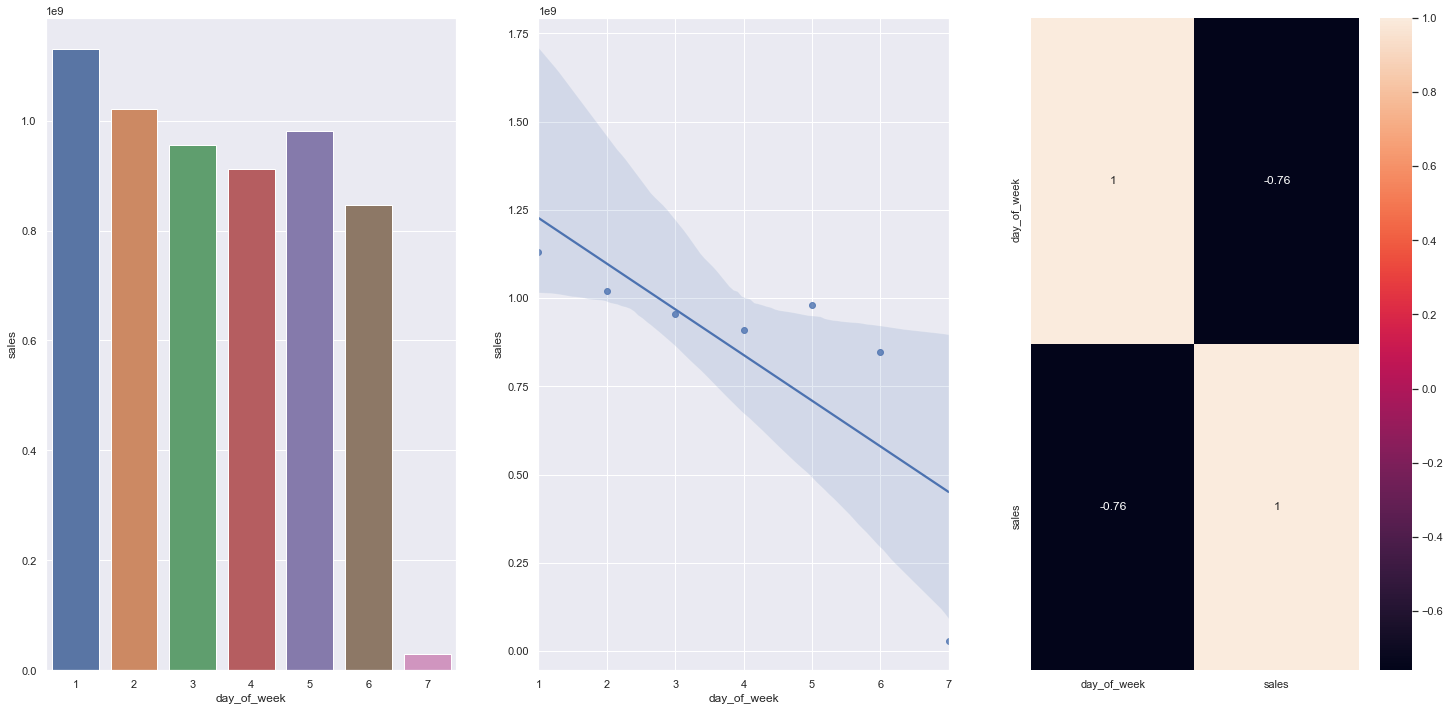

In [44]:
aux1 = df4[["day_of_week","sales"]].groupby("day_of_week").sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x="day_of_week", y="sales", data=aux1);

plt.subplot(1,3,2)
sns.regplot(x="day_of_week", y="sales", data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method="pearson"), annot=True);

### H13. Lojas deveriam vender menos durante os feriados escoalres. 

**VERDADEIRA** Lojas vendem menos durante os feriados escolares. Exceto em julho e agosto que as vendas são maiores por conta das férias escolares. 

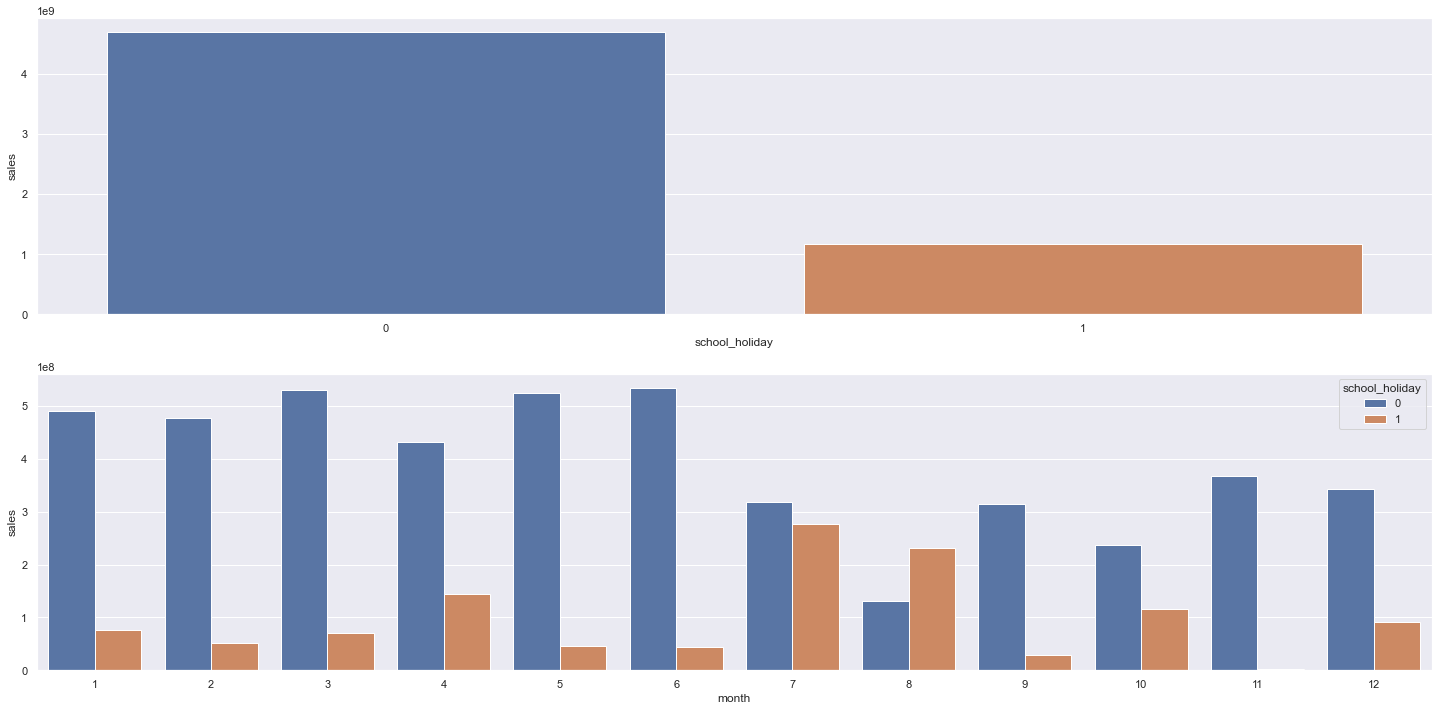

In [45]:
aux1 = df4[["school_holiday", "sales"]].groupby("school_holiday").sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x="school_holiday", y="sales", data=aux1);

aux2 = df4[["month","school_holiday", "sales"]].groupby(["month", "school_holiday"]).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x="month", y="sales",hue="school_holiday", data=aux2);

### 4.2.1 Resumo Hipoteses

In [46]:
tab = [["H1", "CONCLUSAO", " RELEVANCIA"],
      ["H1", "FALSA", "BAIXA"],
      ["H2", "FALSA", "MEDIA"],
      ["H3", "FALSA", "MEDIA"],
      ["H4", "FALSA", "BAIXA"],
      ["H5", "-", "-"],
      ["H6", "FALSA", "BAIXA"],
      ["H7", "FALSA", "MEDIA"],
      ["H8", "FALSA", "ALTA"],
      ["H9", "FALSA", "ALTA"],
      ["H10", "FALSA", "ALTA"],
      ["H11", "VERDADEIRA", "ALTA"],
      ["H12", "VERDADEIRA", "ALTA"],
      ["H13", "VERDADEIRA", "BAIXA"]]

print( tabulate(tab,headers="firstrow") )

H1    CONCLUSAO     RELEVANCIA
----  -----------  -------------
H1    FALSA        BAIXA
H2    FALSA        MEDIA
H3    FALSA        MEDIA
H4    FALSA        BAIXA
H5    -            -
H6    FALSA        BAIXA
H7    FALSA        MEDIA
H8    FALSA        ALTA
H9    FALSA        ALTA
H10   FALSA        ALTA
H11   VERDADEIRA   ALTA
H12   VERDADEIRA   ALTA
H13   VERDADEIRA   BAIXA


## 4.3 Análise Multivariada 

### 4.3.1 Numerical Attributes

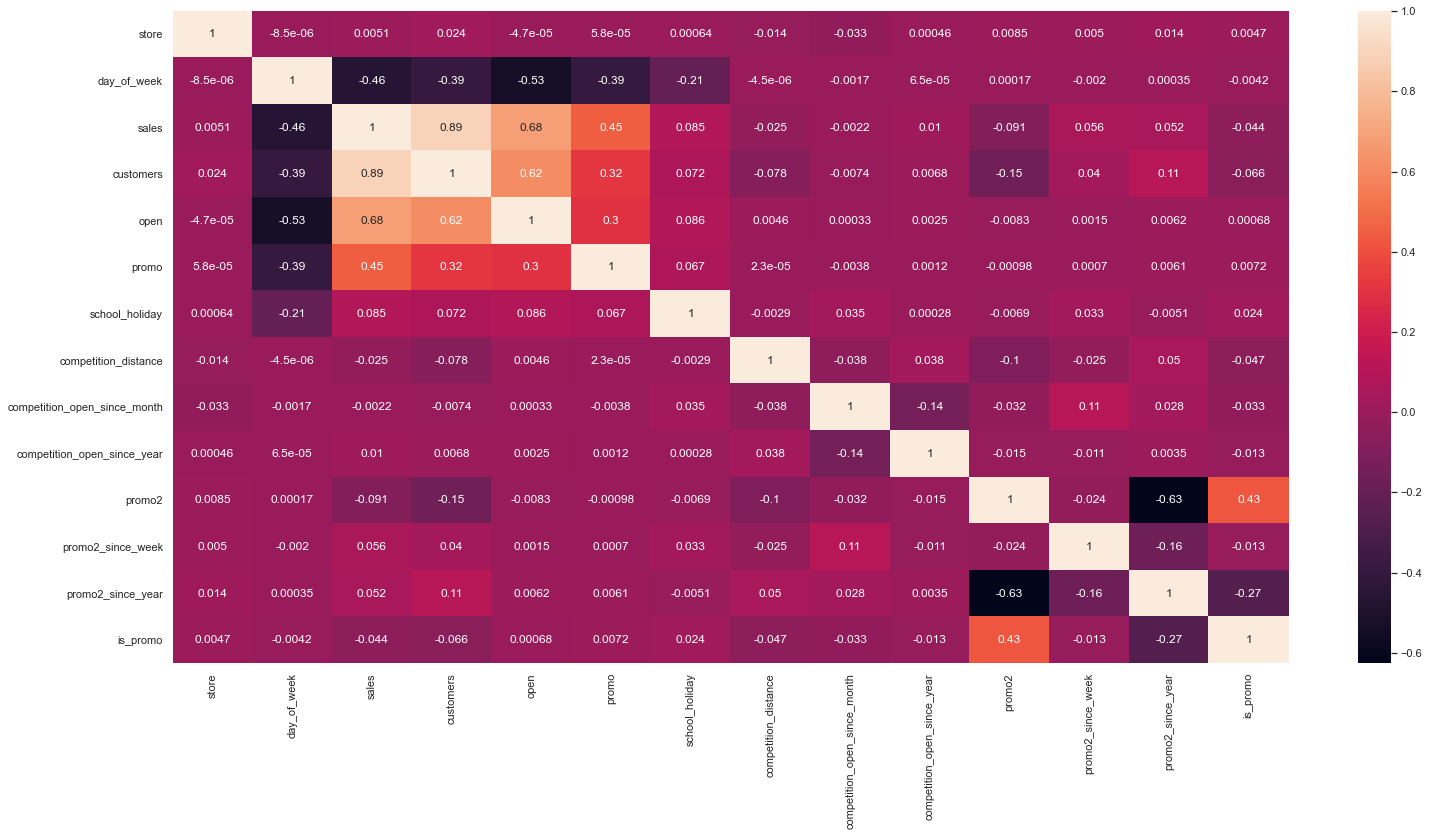

In [47]:
correlation = num_attributes.corr( method = "pearson" )
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes 

<AxesSubplot:>

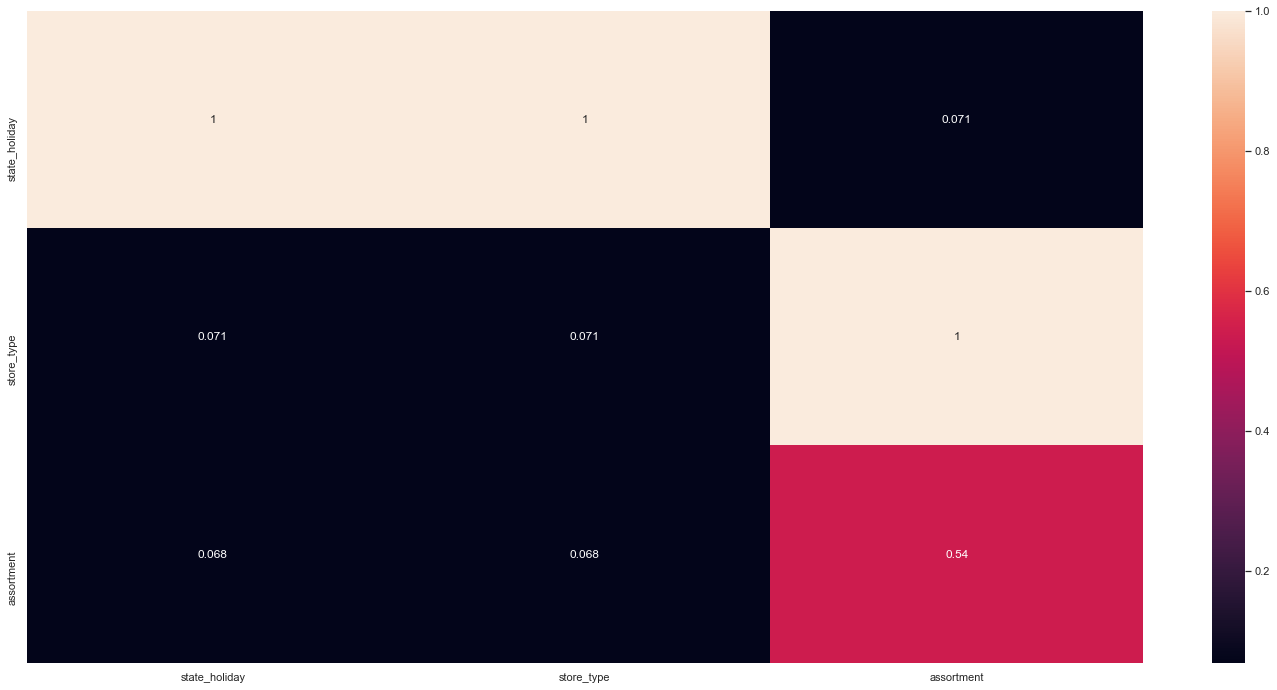

In [48]:
#only categorical data 
a = df4.select_dtypes( include = "object" )

#=========correlação categórica com a função cramer 
a1 = cramer_v(a["state_holiday"], a["state_holiday"])
a2 = cramer_v(a["state_holiday"], a["store_type"])
a3 = cramer_v(a["state_holiday"], a["assortment"])

b1 = cramer_v(a["state_holiday"], a["state_holiday"])
b2 = cramer_v(a["state_holiday"], a["store_type"])
b3 = cramer_v(a["state_holiday"], a["assortment"])

c1 = cramer_v(a["store_type"], a["state_holiday"])
c2 = cramer_v(a["store_type"], a["store_type"])
c3 = cramer_v(a["store_type"], a["assortment"])

d = pd.DataFrame({"state_holiday":[a1, a2, a3], 
                 "store_type": [b1,b2,b3], 
                 "assortment":[c1,c2,c3]
                 })

d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

# 5. Data Preparation

In [49]:
df5 = df4.copy()

## 5.1 Normalização

In [50]:
# Não iremos normalizar. Porque não temos visualizações normalizadas 

## 5.2 Rescaling

In [51]:
rs  = RobustScaler()
mms = MinMaxScaler()

#competition_distance
df5["competition_distance"] = rs.fit_transform( df5[["competition_distance"]].values )

#competition_time_month
df5["competition_time_month"] = rs.fit_transform( df5[["competition_time_month"]].values )

#promo time week 
df5["promo_time_week"] = mms.fit_transform( df5[["promo_time_week"]].values )

#year
df5["year"] = mms.fit_transform( df5[["year"]].values )

## 5.3 Transformation

### 5.3.1 Encoding

In [52]:
#state holiday | One Hot Encoding
df5 = pd.get_dummies(df5, prefix=["state_holiday"], columns=["state_holiday"])

#store_type | Label Encoder
le = LabelEncoder()
df5["store_type"] = le.fit_transform( df5["store_type"] )

#assortment | Ordinal Encoder
assortment_dict = {"basic":1, "extra":2,"extended":3}
df5["assortment"] = df5["assortment"].map( assortment_dict )

### 5.3.2 Response Variable Transformation

In [53]:
df5["sales"] = np.log1p(df5["sales"])

### 5.3.2 Nature Transformation

In [54]:
#day of week 
df5["day_of_week_sin"] = df5["day_of_week"].apply( lambda x: np.sin( x * ( 2 * np.pi/7)))
df5["day_of_week_cos"] = df5["day_of_week"].apply( lambda x: np.cos( x * ( 2 * np.pi/7)))

#month 
df5["month_sin"] = df5["month"].apply( lambda x: np.sin( x * ( 2 * np.pi/12)))
df5["month_cos"] = df5["month"].apply( lambda x: np.cos( x * ( 2 * np.pi/12)))

#day 
df5["day_sin"] = df5["day"].apply( lambda x: np.sin( x * ( 2 * np.pi/30)))
df5["day_cos"] = df5["day"].apply( lambda x: np.cos( x * ( 2 * np.pi/30)))

#week of year
df5["week_of_year_sin"] = df5["week_of_year"].apply( lambda x: np.sin( x * ( 2 * np.pi/52)))
df5["week_of_year_cos"] = df5["week_of_year"].apply( lambda x: np.cos( x * ( 2 * np.pi/52)))

In [55]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_chistmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-5,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-5,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-5,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-5,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-5,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.  Feature Selection

In [56]:
df6 = df5.copy()

In [57]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_chistmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-5,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-5,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-5,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-5,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-5,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


## 6.1 Split dataframe into training and test dataset

In [58]:
cols_drop = ["week_of_year", "day", "month", "day_of_week", "promo_since", "competition_since", "year_week"]
df6 = df6.drop( cols_drop, axis=1)

In [59]:
# training dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']


# test dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print("Training Min Data {}".format( x_train["date"].min()))
print("Training Max Data {}".format(x_train["date"].max() ))

print("\nTest Min Data {}".format( x_test["date"].min()))
print("Test Max Data {}".format(x_test["date"].max()))

Training Min Data 2013-01-01 00:00:00
Training Max Data 2015-06-18 00:00:00

Test Min Data 2015-06-19 00:00:00
Test Max Data 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

from sklearn.ensemble import RandomForestRegressor

training and test dataset for Boruta
x_train_n = x_train.drop(["date","sales"], axis=1).values
y_train_n = y_train.values.ravel()

define RandomForestRegressor 
rf = RandomForestRegressor(n_jobs=-1)

define Boruta
boruta = BorutaPy( rf, n_estimators="auto", verbose=2, random_state= 42 ).fit( x_train_n, y_train_n)

### 6.2.1 Best Features from Boruta

cols_selected = boruta.support_.tolist()

#best features 
x_train_fs = x_train.drop( ["date", "sales"], axis=1)
cols_selected_boruta = x_train_fs.iloc[: , cols_selected].columns.to_list()

#not selected boruta 
cols_not_selected_boruta  = list( np.setdiff1d(x_train_fs.columns , cols_selected_boruta) ) 

## 6.3 Manual Feature Selection

In [60]:
cols_selected_boruta = ['store',
                         'promo',
                         'store_type',
                         'assortment',
                         'competition_distance',
                         'competition_open_since_month',
                         'competition_open_since_year',
                         'promo2',
                         'promo2_since_week',
                         'promo2_since_year',
                         'competition_time_month',
                         'promo_time_week',
                         'day_of_week_sin',
                         'day_of_week_cos',
                         'month_cos',
                         'month_sin',
                         'day_sin',
                         'day_cos',
                         'week_of_year_cos']

cols_not_selected_boruta = ['is_promo',
                             'month_sin',
                             'school_holiday',
                             'state_holiday_chistmas',
                             'state_holiday_easter_holiday',
                             'state_holiday_public_holiday',
                             'state_holiday_regular_day',
                             'week_of_year_sin',
                             'year']

#columns to add 

feat_to_add = ["date",  "sales"]

#final features 
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [61]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [62]:
tab

[['H1', 'CONCLUSAO', ' RELEVANCIA'],
 ['H1', 'FALSA', 'BAIXA'],
 ['H2', 'FALSA', 'MEDIA'],
 ['H3', 'FALSA', 'MEDIA'],
 ['H4', 'FALSA', 'BAIXA'],
 ['H5', '-', '-'],
 ['H6', 'FALSA', 'BAIXA'],
 ['H7', 'FALSA', 'MEDIA'],
 ['H8', 'FALSA', 'ALTA'],
 ['H9', 'FALSA', 'ALTA'],
 ['H10', 'FALSA', 'ALTA'],
 ['H11', 'VERDADEIRA', 'ALTA'],
 ['H12', 'VERDADEIRA', 'ALTA'],
 ['H13', 'VERDADEIRA', 'BAIXA']]

O boruta analisou como relevanvte todas as nossas hipóteses somente a hipótese referente ao ano o Boruta não viu como relevante

# 7. Machine Learning Modelling

In [63]:
df7 = df6.copy()

In [101]:
df7.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_chistmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,1.054054,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,1.202703,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,-0.162162,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [102]:
x_trains = x_train[ cols_selected_boruta ]
x_tests = x_test[ cols_selected_boruta ]

#Time Series Data Preparation
x = df6[df6['date'] < '2015-06-19']
x_training = x[cols_selected_boruta_full]

## 7.1 Average Model

In [103]:
aux1 = x_test.copy()
aux["sales"] =  y_test.copy()

#prediction
aux2 = aux1[["store","sales"]].groupby("store").mean().reset_index().rename( columns={"sales":"predictions"} )
aux1 = pd.merge(aux1, aux2, how="left", on="store")
yhat_baseline = aux1["predictions"]

x_train = x_train.astype(int64)
y_train = y_train.astype(int64)
x_test = x_test.astype(int64)


#performance
baseline_result = m1_error( "Average Model:", np.expm1( y_test ), np.expm1( yhat_baseline ))

baseline_result

<ipython-input-103-de7260a6c933>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux["sales"] =  y_test.copy()


,Model Name:,MAE,MAPE,RMSE
0,Average Model:,2975.989578,0.45871,3617.114078


## 7.2 Linear Regression Model

In [104]:
# model
lr = LinearRegression().fit( x_train, y_train )
# prediction
yhat_lr = lr.predict( x_test )
# performance
lr_result = m1_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ) )
lr_result

,Model Name:,MAE,MAPE,RMSE
0,Linear Regression,3148.11159,0.387764,4244.475018


### 7.2.1 Linear Regression Model - Cross Validation

In [105]:
model = LinearRegression()
linear = cross_validation( x_training , 5, "Linear Regression", model )
linear

KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMS CV
0,Linear Regression,2080.69 +/- 293.36,0.3 +/- 0.02,2950.49 +/- 464.71


## 7.3 Linear Regression Regularized Model - Lasso

In [106]:
# model
lrr = Lasso(alpha = 0.01).fit( x_train, y_train )
# prediction
yhat_lrr = lrr.predict( x_test )
# performance
lrr_result = m1_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1(yhat_lrr ) )
lrr_result

C:\Users\guisg\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7111.0153512619245, tolerance: 21.318467282194163
  model = cd_fast.enet_coordinate_descent(


,Model Name:,MAE,MAPE,RMSE
0,Linear Regression - Lasso,2661.232217,0.381964,3178.581765


### 7.3.1 Linear Regression Regularized Model - Cross Validation

In [107]:
model = Lasso(alpha = 0.01)
lasso = cross_validation( x_training , 5, "Lasso Regression", model )
lasso

KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMS CV
0,Lasso Regression,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Conclusion Linar Model

Meu modelo de média é muit superior do que de regressão linear. Os meus dados tem um comportamento complexo e **não linear**

Precisamos implementar os modelos não lineares

## 7.5 Random Forest Regressor

In [73]:
# model
rf = RandomForestRegressor(n_estimators= 100, n_jobs=-1, random_state=42).fit( x_train, y_train )


# prediction
yhat_rf = rf.predict( x_test )


# performance
rf_result = m1_error( 'Random Forest Regression: ', np.expm1( y_test ), np.expm1(yhat_rf ) )
rf_result

,Model Name:,MAE,MAPE,RMSE
0,Random Forest Regression:,2624.962545,0.38125,3146.412025


In [74]:
model = RandomForestRegressor(n_estimators= 100, n_jobs=-1, random_state=42)
forest = cross_validation( x_training , 5, "Random Forest", model )
forest

KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMS CV
0,Random Forest,839.75 +/- 218.46,0.12 +/- 0.02,1258.77 +/- 319.5


## 7.6 XGBoost Regressor

In [108]:
#model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytee=0.9).fit( x_train, y_train )


# prediction
yhat_xgb = model_xgb.predict( x_test )


# performance
xgb_result = m1_error( 'XGBOOST: ', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

[11:50:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name:,MAE,MAPE,RMSE
0,XGBOOST:,6759.943107,0.964334,7386.450202


### 7.6.1 XGBoost Regressor - Cross Validation

In [109]:
model = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators=100,
                         eta=0.01,
                         max_depth=10,
                         subsample=0.7,
                         colsample_bytee=0.9 )

xgbre = cross_validation( x_training , 5, "XGBoost Regressor", model )
xgbre

KFold Number: 5
[11:50:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


KFold Number: 4
[11:51:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


KFold Number: 3
[11:51:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Pa

,Model Name,MAE CV,MAPE CV,RMS CV
0,XGBoost Regressor,7047.98 +/- 587.64,0.95 +/- 0.0,7714.07 +/- 688.72


## 7.7 Compare Model's Performance

### 7.7.1 Single Performance 

In [110]:
modelind_result = pd.concat([baseline_result, lr_result, lrr_result,rf_result, xgb_result])
modelling_result.sort_values( 'RMSE' )

NameError: name 'rf_result' is not defined

Não representa a realidade precisamos fazer uma validação do melhor elemento

### 7.7.2 Real Performance - Cross Validation

In [ ]:
modeling = pd.concat([linear, lasso, forest, xgbre])
modeling.sort_values( 'RMS CV' )

Para fins didáticos vamos aplicar o XGBoost, porém o ideal segundo o RMS CV seria aplicarmos o Random Forest

# 8. Hyperparameter Fine Tuning

## 8.1 Random Search

In [84]:
import ramdom 
param = {'n_estimators': [15, 17, 25, 30, 35],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]
         }

MAX_EVAL = 5

ModuleNotFoundError: No module named 'ramdom'

In [87]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = {k: random.choice(v) for k, v in param.items()}    
    print( hp )

    # model
    model_xgb = xgb.XGBRegressor(   objective='reg:squarederror',
                                    n_estimators=hp['n_estimators'],
                                    eta=hp['eta'],
                                    max_depth=hp['max_depth'],
                                    subsample=hp['subsample'],
                                    colsample_bytee=hp['colsample_bytree'],
                                    min_child_weight=hp['min_child_weight'] )
    # performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb )
    final_result = pd.concat( [final_result, result] )

final_result

{'n_estimators': 25, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}
KFold Number: 5
[11:26:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


KFold Number: 4
[11:26:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


KFol

KeyboardInterrupt: 

## 8.2 Final Model

In [88]:
param_tuned = {
                'n_estimators': 3000,
                'eta': 0.03,
                'max_depth': 5,
                'subsample': 0.7,
                'colsample_bytree': 0.7,
                'min_child_weight': 3
            }

In [100]:
#model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=3000,
                             eta=0.03,
                             max_depth=5,
                             subsample=0.7,
                             colsample_bytee=0.7,
                             min_child_weight=3).fit( x_train, y_train )


# prediction
yhat_xgb = model_xgb.predict( x_test )


# performance
xgb_result = m1_error( 'XGBOOST: ', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

[11:35:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name:,MAE,MAPE,RMSE
0,XGBOOST:,2625.012133,0.381257,3146.453438
